In [39]:
%matplotlib notebook

### reference: https://towardsdatascience.com/attention-seq2seq-with-pytorch-learning-to-invert-a-sequence-34faf4133e53

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F

In [3]:
torch.__version__

'1.7.0+cu101'

In [4]:
torch.__version__

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
MAX_LENGTH = 15

In [6]:
inverse_map = {
    'a':'z',
    'b':'y',
    'c':'x',
    'd':'w',
    'e':'v',
    'f':'u',
    'g':'t',
    'h':'s',
    'i':'r',
    'j':'q',
    'k':'p',
    'l':'o',
    'm':'n',
    'n':'m',
    'o':'l',
    'p':'k',
    'q':'j',
    'r':'i',
    's':'h',
    't':'g',
    'u':'f',
    'v':'e',
    'w':'d',
    'x':'c',
    'y':'b',
    'z':'a'
}

In [7]:
a2i = {
    '<s>':0,
    '</s>':1,
    '<pad>':2,
    'a':3,
    'b':4,
    'c':5,
    'd':6,
    'e':7,
    'f':8,
    'g':9,
    'h':10,
    'i':11,
    'j':12,
    'k':13,
    'l':14,
    'm':15,
    'n':16,
    'o':17,
    'p':18,
    'q':19,
    'r':20,
    's':21,
    't':22,
    'u':23,
    'v':24,
    'w':25,
    'x':26,
    'y':27,
    'z':28,
}

In [8]:
i2a = {v:k for k, v in a2i.items()}

In [9]:
i2a

{0: '<s>',
 1: '</s>',
 2: '<pad>',
 3: 'a',
 4: 'b',
 5: 'c',
 6: 'd',
 7: 'e',
 8: 'f',
 9: 'g',
 10: 'h',
 11: 'i',
 12: 'j',
 13: 'k',
 14: 'l',
 15: 'm',
 16: 'n',
 17: 'o',
 18: 'p',
 19: 'q',
 20: 'r',
 21: 's',
 22: 't',
 23: 'u',
 24: 'v',
 25: 'w',
 26: 'x',
 27: 'y',
 28: 'z'}

In [10]:
def generate_random_alphabet_index():
    random_length = np.random.randint(5, MAX_LENGTH-2)    # -2 because of <s> and </s>
    random_alphabet_index = np.random.randint(0, 26, random_length) + 3
    return random_alphabet_index.tolist()

In [11]:
class AlphabetToyDataset(Dataset):
    def __init__(self, n_dataset=1000):
        bos = 0
        eos = 1
        pad = 2
        self.inputs = []
        self.labels = []
        for _ in range(n_dataset):
            # make input example
            aindex = generate_random_alphabet_index()
            
            # index to alphabet
            #alphabet = list(map(lambda a: i2a[a], aindex))
            
            # inversing
            #inversed_alphabet = list(map(lambda a: inverse_map[a], alphabet))
            
            # alphabet to index
            #iindex = list(map(lambda ia: a2i[ia], inversed_alphabet))
            iindex = aindex[::-1]
            
            # add bos, eos and pad
            n_pad = MAX_LENGTH - len(aindex) - 2
            aindex = aindex + [eos]
            iindex = iindex + [eos]
            
            # add to examples
            self.inputs.append(aindex)
            self.labels.append(iindex)
            
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return [
            torch.tensor(self.inputs[index], dtype=torch.long),
            torch.tensor(self.labels[index], dtype=torch.long)
        ]

In [12]:
# class AlphabetToyDataset(Dataset):
#     def __init__(self, n_dataset=1000):
#         bos = 0
#         eos = 1
#         pad = 2
#         self.inputs = []
#         self.labels = []
#         for _ in range(n_dataset):
#             # make input example
#             aindex = generate_random_alphabet_index()
            
#             # index to alphabet
#             alphabet = list(map(lambda a: i2a[a], aindex))
            
#             # inversing
#             inversed_alphabet = list(map(lambda a: inverse_map[a], alphabet))
            
#             # alphabet to index
#             iindex = list(map(lambda ia: a2i[ia], inversed_alphabet))
            
#             # add bos, eos and pad
#             n_pad = MAX_LENGTH - len(aindex) - 2
#             aindex = aindex + [eos]
#             iindex = iindex + [eos]
            
#             # add to examples
#             self.inputs.append(aindex)
#             self.labels.append(iindex)
            
#     def __len__(self):
#         return len(self.inputs)
    
#     def __getitem__(self, index):
#         return [
#             torch.tensor(self.inputs[index], dtype=torch.long),
#             torch.tensor(self.labels[index], dtype=torch.long)
#         ]

In [13]:
train_dataset = AlphabetToyDataset(n_dataset=3000)
valid_dataset = AlphabetToyDataset(n_dataset=300)

In [14]:
len(train_dataset), len(valid_dataset)

(3000, 300)

In [15]:
def convert_index_to_alphabet(index):
    alphabet = list(map(lambda i: i2a[i], index))
    return ' '.join(alphabet)

In [16]:
for i in range(3):
    ex = train_dataset[i]
    aindex, iindex = ex
    
    print('aindex_{}: {}'.format(len(aindex), convert_index_to_alphabet(aindex.numpy())))
    print('iindex_{}: {}'.format(len(iindex), convert_index_to_alphabet(iindex.numpy())))
    print('** aindex_{}: {}'.format(len(aindex), aindex))
    print('** iindex_{}: {}'.format(len(iindex), iindex))
    print('------------')

aindex_8: t d g m k x b </s>
iindex_8: b x k m g d t </s>
** aindex_8: tensor([22,  6,  9, 15, 13, 26,  4,  1])
** iindex_8: tensor([ 4, 26, 13, 15,  9,  6, 22,  1])
------------
aindex_12: g u t j l f f l i n w </s>
iindex_12: w n i l f f l j t u g </s>
** aindex_12: tensor([ 9, 23, 22, 12, 14,  8,  8, 14, 11, 16, 25,  1])
** iindex_12: tensor([25, 16, 11, 14,  8,  8, 14, 12, 22, 23,  9,  1])
------------
aindex_8: z q d v g v z </s>
iindex_8: z v g v d q z </s>
** aindex_8: tensor([28, 19,  6, 24,  9, 24, 28,  1])
** iindex_8: tensor([28, 24,  9, 24,  6, 19, 28,  1])
------------


In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=1)
valid_dataloader = DataLoader(valid_dataset, batch_size=1)

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [19]:
# without Attention
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        #print('DecoderRNN_INPUT: input: {} → {:.4f}'.format(input.shape, input.sum()))
        #print('DecoderRNN_INPUT: hidden: {} → {:.4f}'.format(hidden.shape, hidden.sum()))
        
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        #print('** output: {} → {:.4f}'.format(output.shape, output.sum()))
        
        
        output, hidden = self.gru(output, hidden)
        #print('** gru-output: {} → {:.4f}'.format(output.shape, output.sum()))
        #print('** gru-hidden: {} → {:.4f}'.format(hidden.shape, hidden.sum()))
        
        output = self.softmax(self.out(output[0]))
        #print('** hidden: {}'.format(hidden.shape))
        
        #print('DecoderRNN_OUTPUT: output: {} → {:.4f}'.format(output.shape, output.sum()))
        #print('DecoderRNN_OUTPUT: hidden: {} → {:.4f}'.format(hidden.shape, hidden.sum()))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
# with attention
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #print('** embedded: {}'.format(embedded.shape))
        #print('** hidden: {}'.format(hidden.shape))
        #print('** encoder_outputs: {}'.format(encoder_outputs.shape))
        #return
        #print('AttnDecoderRNN_INPUT: input → embedded: {} → {}'.format(input.shape, embedded.shape))
        #print('AttnDecoderRNN_INPUT: hidden: {}'.format(hidden.shape))
        #print('AttnDecoderRNN_INPUT: encoder_outputs: {}'.format(encoder_outputs.shape))
        
        #print('** embedded[0]: {}'.format(embedded[0].shape))
        #print('** hidden[0]: {}'.format(hidden[0].shape))
        #print('** concatenate embedded[0] and hidden[0]: {}'.format(torch.cat((embedded[0], hidden[0]), 1).shape))
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        #print('** attn_weights: {}'.format(attn_weights.shape))
        #print('** attn_weights: {}'.format(attn_weights))
        #print('** attn_weights.sum(): {}'.format(attn_weights.sum().shape))
        #print('** attn_weights.sum(): {:.4f}'.format(attn_weights.sum()))
        
        #print('** attn_weights unsqueezed: {}'.format(attn_weights.unsqueeze(0).shape))
        #print('** encoder_outputs unsqueezed: {}'.format(encoder_outputs.unsqueeze(0).shape))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        #print('** attn_applied: {}'.format(attn_applied.shape))
        #print('** attn_applied[0]: {}'.format(attn_applied[0].shape))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        #print('** output: {}'.format(output.shape))
        output = self.attn_combine(output).unsqueeze(0)
        #print('** output: {}'.format(output.shape))
        
        output = F.relu(output)
        #print('** output: {}'.format(output.shape))
        output, hidden = self.gru(output, hidden)
        #print('** gru-output: {}'.format(output.shape))
        #print('** gru-hidden: {}'.format(hidden.shape))

        #print('** output: {}'.format(output[0].shape))
        #print('** self.out: {}'.format(self.out))
        output = F.log_softmax(self.out(output[0]), dim=1)
        #print('AttnDecoderRNN_OUTPUT: {}'.format(output.shape))
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
teacher_forcing_ratio = 0.5

In [22]:
bos = 0
eos = 1
pad = 2

In [23]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH, with_attention=True):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    #print('** input_tensor[0]: {}'.format(input_tensor[0]))
    #print('** target_tensor[0]: {}'.format(target_tensor[0]))
    #return

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    #print('encoder_outputs: {}'.format(encoder_outputs.shape))
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        #print('{} - {}'.format(ei, encoder_output[0, 0].shape))

    decoder_input = torch.tensor([[bos]], device=device)

    decoder_hidden = encoder_hidden
    #print('decoder_hidden: {}'.format(decoder_hidden.shape))

    use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            if with_attention:
                #print('# {}th decoding'.format(di))
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                #print('train:decoder_attention_{}: {}'.format(di, decoder_attention.shape))
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
            

    else:
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            if with_attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                #print('train:decoder_attention_{}: {}'.format(di, decoder_attention.shape))
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == eos:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [24]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [25]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, with_attention=True):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    #training_pairs = [tensorsFromPair(random.choice(pairs))
    #                  for i in range(n_iters)]
    criterion = nn.NLLLoss()

    #for iter in range(1, n_iters + 1):
    for iter, batch in enumerate(train_dataloader):
        input_tensor, target_tensor = batch
        input_tensor = input_tensor.squeeze(0).unsqueeze(-1).to(device)
        target_tensor = target_tensor.squeeze(0).unsqueeze(-1).to(device)
        #print(input_tensor.shape, target_tensor.shape)
        #print(input_tensor)
        #print(target_tensor)
        #print('----------')
        #return
        #print(input_tensor)
        #print(target_tensor)
        #return
        #training_pair = training_pairs[iter - 1]
        #input_tensor = training_pair[0]
        #target_tensor = training_pair[1]
        

        #print(input_tensor.shape, target_tensor.shape)
        #print(input_tensor)
        #print(target_tensor)
        #print('----------------------')
        
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, with_attention=with_attention)
        print_loss_total += loss
        plot_loss_total += loss

        if (iter+1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, (iter+1) / n_iters),
                                         (iter+1), (iter+1) / n_iters * 100, print_loss_avg))

        if (iter+1) % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [26]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [27]:
def evaluate(encoder, decoder, input_tensor, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = input_tensor.squeeze(0).unsqueeze(-1)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[bos]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == eos:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(i2a[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [28]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [29]:
for t in train_dataloader:
    print(t)
    break

[tensor([[22,  6,  9, 15, 13, 26,  4,  1]]), tensor([[ 4, 26, 13, 15,  9,  6, 22,  1]])]


In [30]:
hidden_size = 256
encoder1 = EncoderRNN(26+3, hidden_size).to(device)
decoder1 = AttnDecoderRNN(hidden_size, 26+3, dropout_p=0.1).to(device)

In [31]:
# hidden_size = 256
# encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
# decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

In [32]:
#### Input validation

In [33]:
# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [34]:
trainIters(encoder1, decoder1, 75000, print_every=100, with_attention=True)

0m 4s (- 55m 31s) (100 0%) 2.4223
0m 9s (- 57m 18s) (200 0%) 2.4680
0m 13s (- 56m 57s) (300 0%) 2.5869
0m 18s (- 56m 34s) (400 0%) 2.7725
0m 22s (- 55m 37s) (500 0%) 2.5374
0m 26s (- 55m 7s) (600 0%) 2.4361
0m 30s (- 54m 27s) (700 0%) 2.3038
0m 35s (- 54m 45s) (800 1%) 2.2666
0m 40s (- 55m 14s) (900 1%) 2.1829
0m 45s (- 55m 42s) (1000 1%) 2.0895
0m 50s (- 56m 4s) (1100 1%) 2.0440
0m 55s (- 56m 26s) (1200 1%) 2.0254
1m 0s (- 56m 41s) (1300 1%) 1.9361
1m 4s (- 56m 33s) (1400 1%) 1.8139
1m 9s (- 56m 23s) (1500 2%) 1.8857
1m 13s (- 56m 11s) (1600 2%) 1.7098
1m 18s (- 56m 4s) (1700 2%) 1.7667
1m 22s (- 56m 9s) (1800 2%) 1.6412
1m 27s (- 56m 14s) (1900 2%) 1.7400
1m 32s (- 56m 14s) (2000 2%) 1.6828
1m 36s (- 56m 2s) (2100 2%) 1.6970
1m 41s (- 55m 51s) (2200 2%) 1.6419
1m 45s (- 55m 41s) (2300 3%) 1.5891
1m 50s (- 55m 29s) (2400 3%) 1.5596
1m 54s (- 55m 16s) (2500 3%) 1.4661
1m 58s (- 55m 5s) (2600 3%) 1.5951
2m 3s (- 54m 55s) (2700 3%) 1.5352
2m 7s (- 54m 49s) (2800 3%) 1.5377
2m 11s (- 54m 

In [35]:
trainIters(encoder1, decoder1, 75000, print_every=100, with_attention=True)

0m 4s (- 54m 0s) (100 0%) 1.3931
0m 8s (- 55m 54s) (200 0%) 1.5819
0m 13s (- 55m 58s) (300 0%) 1.4547
0m 18s (- 56m 1s) (400 0%) 1.4659
0m 22s (- 56m 2s) (500 0%) 1.4217
0m 27s (- 56m 2s) (600 0%) 1.4516
0m 31s (- 55m 36s) (700 0%) 1.2930
0m 36s (- 55m 47s) (800 1%) 1.4072
0m 40s (- 55m 47s) (900 1%) 1.3555
0m 45s (- 55m 52s) (1000 1%) 1.3093
0m 49s (- 55m 48s) (1100 1%) 1.3020
0m 54s (- 55m 49s) (1200 1%) 1.2739
0m 59s (- 55m 46s) (1300 1%) 1.3730
1m 3s (- 55m 41s) (1400 1%) 1.4046
1m 8s (- 55m 54s) (1500 2%) 1.3739
1m 13s (- 56m 12s) (1600 2%) 1.3081
1m 18s (- 56m 30s) (1700 2%) 1.3362
1m 23s (- 56m 47s) (1800 2%) 1.3393
1m 28s (- 56m 56s) (1900 2%) 1.3651
1m 33s (- 56m 53s) (2000 2%) 1.3021
1m 38s (- 56m 44s) (2100 2%) 1.3166
1m 42s (- 56m 36s) (2200 2%) 1.3146
1m 47s (- 56m 30s) (2300 3%) 1.2727
1m 51s (- 56m 21s) (2400 3%) 1.2898
1m 56s (- 56m 8s) (2500 3%) 1.1813
2m 0s (- 55m 57s) (2600 3%) 1.1900
2m 4s (- 55m 45s) (2700 3%) 1.2196
2m 9s (- 55m 38s) (2800 3%) 1.2640
2m 13s (- 55m

In [36]:
trainIters(encoder1, decoder1, 75000, print_every=100, with_attention=True)

0m 4s (- 53m 22s) (100 0%) 1.1964
0m 8s (- 54m 45s) (200 0%) 1.2139
0m 13s (- 54m 56s) (300 0%) 1.1150
0m 18s (- 56m 1s) (400 0%) 1.0885
0m 23s (- 57m 22s) (500 0%) 1.0807
0m 28s (- 58m 29s) (600 0%) 1.2452
0m 33s (- 58m 43s) (700 0%) 1.0503
0m 38s (- 59m 30s) (800 1%) 1.1642
0m 43s (- 59m 50s) (900 1%) 1.1855
0m 48s (- 59m 27s) (1000 1%) 1.1976
0m 52s (- 59m 9s) (1100 1%) 1.1344
0m 57s (- 58m 57s) (1200 1%) 1.1493
1m 1s (- 58m 34s) (1300 1%) 1.1384
1m 6s (- 58m 18s) (1400 1%) 1.1481
1m 11s (- 58m 10s) (1500 2%) 1.1679
1m 15s (- 57m 58s) (1600 2%) 1.0797
1m 20s (- 57m 48s) (1700 2%) 1.0640
1m 25s (- 57m 41s) (1800 2%) 1.1544
1m 29s (- 57m 37s) (1900 2%) 1.1651
1m 34s (- 57m 38s) (2000 2%) 1.2608
1m 39s (- 57m 28s) (2100 2%) 1.0967
1m 43s (- 57m 20s) (2200 2%) 1.0950
1m 48s (- 57m 14s) (2300 3%) 1.1153
1m 53s (- 57m 5s) (2400 3%) 1.0909
1m 57s (- 56m 53s) (2500 3%) 1.0541
2m 2s (- 56m 42s) (2600 3%) 1.1266
2m 6s (- 56m 32s) (2700 3%) 1.0525
2m 11s (- 56m 40s) (2800 3%) 1.0818
2m 16s (- 

In [37]:
for d in valid_dataloader:
    input_tensor, target_tensor = d
    input_string = list(map(lambda i: i2a[i], input_tensor.numpy()[0]))
    output_string = list(map(lambda i: i2a[i], target_tensor.numpy()[0]))
    input_string = np.array(input_string)
    output_string = np.array(output_string)
    print('input: {}'.format(input_string))
    print('output: {}'.format(output_string))
    
    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)
    pred, attn_weight = evaluate(encoder1, decoder1, input_tensor)
    pred = np.array(pred)
    print('pred: {}'.format(pred))
    print('-------------')

input: ['e' 'h' 'y' 'f' 'p' 'u' 'g' 'b' '</s>']
output: ['b' 'g' 'u' 'p' 'f' 'y' 'h' 'e' '</s>']
pred: ['b' 'g' 'u' 'p' 'y' 'h' '<EOS>']
-------------
input: ['f' 'n' 'b' 'c' 'l' 'u' 'k' 'q' '</s>']
output: ['q' 'k' 'u' 'l' 'c' 'b' 'n' 'f' '</s>']
pred: ['q' 'k' 'u' 'l' 'u' 'b' 'n' 'c' 'n' '<EOS>']
-------------
input: ['n' 'p' 'd' 'r' 'c' 'o' 'e' 'x' '</s>']
output: ['x' 'e' 'o' 'c' 'r' 'd' 'p' 'n' '</s>']
pred: ['x' 'e' 'o' 'r' 'c' 'n' 'p' '<EOS>']
-------------
input: ['l' 'w' 'a' 'u' 'k' '</s>']
output: ['k' 'u' 'a' 'w' 'l' '</s>']
pred: ['k' 'u' 'a' 'w' 'l' 'u' 'w' '<EOS>']
-------------
input: ['h' 'w' 'y' 'g' 's' 'x' 'x' 'n' 'x' '</s>']
output: ['x' 'n' 'x' 'x' 's' 'g' 'y' 'w' 'h' '</s>']
pred: ['x' 'x' 'n' 'x' 'x' 's' 'w' 'y' 'g' 'h' 'w' '<EOS>']
-------------
input: ['l' 'a' 'h' 'h' 'b' 'a' 'g' 'z' '</s>']
output: ['z' 'g' 'a' 'b' 'h' 'h' 'a' 'l' '</s>']
pred: ['z' 'g' 'b' 'a' 'h' 'l' '<EOS>']
-------------
input: ['h' 'j' 'd' 'a' 'i' 'l' 'z' 'r' '</s>']
output: ['r' 'z' 'l' '

pred: ['w' 'j' 't' 'j' 'p' 'r' 'i' 't' 'm' '<EOS>']
-------------
input: ['n' 'm' 's' 'e' 'c' 'x' '</s>']
output: ['x' 'c' 'e' 's' 'm' 'n' '</s>']
pred: ['x' 'c' 'e' 's' 'm' 'n' '<EOS>']
-------------
input: ['u' 'j' 'b' 'e' 'b' 'g' 'q' 'o' 'n' 'l' 'z' '</s>']
output: ['z' 'l' 'n' 'o' 'q' 'g' 'b' 'e' 'b' 'j' 'u' '</s>']
pred: ['z' 'l' 'n' 'g' 'q' 'b' 'b' 'e' 'u' 'j' 'u' '<EOS>']
-------------
input: ['x' 'a' 'l' 'w' 'b' 'b' 'k' 'e' '</s>']
output: ['e' 'k' 'b' 'b' 'w' 'l' 'a' 'x' '</s>']
pred: ['e' 'b' 'k' 'e' 'w' 'l' 'a' 'x' '<EOS>']
-------------
input: ['n' 'o' 'h' 'n' 'r' 'n' 'i' 'w' 'f' 'y' 'u' 'i' '</s>']
output: ['i' 'u' 'y' 'f' 'w' 'i' 'n' 'r' 'n' 'h' 'o' 'n' '</s>']
pred: ['i' 'u' 'f' 'y' 'i' 'n' 'w' 'r' 'h' 'o' 'n' '<EOS>']
-------------
input: ['g' 'q' 'b' 'u' 'c' 't' 'y' 'n' '</s>']
output: ['n' 'y' 't' 'c' 'u' 'b' 'q' 'g' '</s>']
pred: ['n' 'y' 't' 'u' 'q' 'n' 'b' 'q' 'g' 'q' '<EOS>']
-------------
input: ['a' 'd' 'f' 'l' 'q' 'q' '</s>']
output: ['q' 'q' 'l' 'f' 'd' 'a' '<

pred: ['v' 'b' 'u' 'f' 't' 'i' 'c' '<EOS>']
-------------
input: ['p' 'x' 'v' 'x' 'w' 'z' 'q' 'p' '</s>']
output: ['p' 'q' 'z' 'w' 'x' 'v' 'x' 'p' '</s>']
pred: ['p' 'q' 'z' 'w' 'x' 'v' 'x' 'p' '<EOS>']
-------------
input: ['f' 'c' 'f' 'o' 'v' '</s>']
output: ['v' 'o' 'f' 'c' 'f' '</s>']
pred: ['v' 'o' 'f' 'c' 'o' '<EOS>']
-------------
input: ['f' 'c' 'r' 'k' 'u' 'x' 'g' 'x' 't' '</s>']
output: ['t' 'x' 'g' 'x' 'u' 'k' 'r' 'c' 'f' '</s>']
pred: ['t' 'x' 'k' 'u' 'x' 'x' 'x' 'x' 'k' 'c' '<EOS>']
-------------
input: ['b' 'c' 'c' 'y' 'w' 'u' 'g' 's' 'x' 'x' '</s>']
output: ['x' 'x' 's' 'g' 'u' 'w' 'y' 'c' 'c' 'b' '</s>']
pred: ['x' 'x' 's' 'x' 'u' 'g' 'w' 'y' 'c' 'b' '<EOS>']
-------------
input: ['t' 't' 'h' 'x' 'r' 'f' 'e' 'w' 'x' '</s>']
output: ['x' 'w' 'e' 'f' 'r' 'x' 'h' 't' 't' '</s>']
pred: ['x' 'f' 'x' 'w' 'e' 'r' 'h' 'h' 't' '<EOS>']
-------------
input: ['k' 'z' 'e' 'o' 'o' 'r' 'p' 'z' 'h' '</s>']
output: ['h' 'z' 'p' 'r' 'o' 'o' 'e' 'z' 'k' '</s>']
pred: ['h' 'z' 'p' 'r' 'o'

pred: ['n' 'k' 'u' 'j' 'n' 'n' 'j' 'f' '<EOS>']
-------------
input: ['v' 't' 'j' 'm' 'i' 't' 'g' 'v' 'l' 'j' 'd' 'a' '</s>']
output: ['a' 'd' 'j' 'l' 'v' 'g' 't' 'i' 'm' 'j' 't' 'v' '</s>']
pred: ['a' 'd' 'j' 'l' 't' 'v' 'm' 'j' 'g' 't' 't' '<EOS>']
-------------
input: ['d' 'u' 'p' 'x' 'h' 'v' 'm' '</s>']
output: ['m' 'v' 'h' 'x' 'p' 'u' 'd' '</s>']
pred: ['m' 'v' 'h' 'p' 'u' '<EOS>']
-------------
input: ['u' 'e' 'a' 'g' 'u' '</s>']
output: ['u' 'g' 'a' 'e' 'u' '</s>']
pred: ['u' 'g' 'e' 'a' 'u' 'u' '<EOS>']
-------------
input: ['c' 'y' 'v' 'o' 'x' '</s>']
output: ['x' 'o' 'v' 'y' 'c' '</s>']
pred: ['x' 'o' 'v' 'y' 'o' 'c' '<EOS>']
-------------
input: ['z' 'z' 'a' 't' 'v' 'y' 'm' 'a' 'k' 'e' 'x' 'u' '</s>']
output: ['u' 'x' 'e' 'k' 'a' 'm' 'y' 'v' 't' 'a' 'z' 'z' '</s>']
pred: ['u' 'x' 'e' 'k' 'a' 'u' 'y' 'z' 't' 'a' 'k' 't' '<EOS>']
-------------
input: ['l' 'c' 'p' 'f' 'j' 'y' 'n' 'v' 'o' 'z' 'v' 'j' '</s>']
output: ['j' 'v' 'z' 'o' 'v' 'n' 'y' 'j' 'f' 'p' 'c' 'l' '</s>']
pred: 

pred: ['b' 'h' 'w' 'j' 'w' 'j' 'i' 'j' 'x' 's' '<EOS>']
-------------
input: ['x' 'u' 'b' 'j' 'o' 'q' 'e' 'i' 'q' 'a' '</s>']
output: ['a' 'q' 'i' 'e' 'q' 'o' 'j' 'b' 'u' 'x' '</s>']
pred: ['a' 'q' 'i' 'e' 'o' 'b' 'u' 'x' 'x' 'u' '<EOS>']
-------------
input: ['j' 'c' 's' 'n' 'i' 'c' 'g' 'j' 'y' 'q' '</s>']
output: ['q' 'y' 'j' 'g' 'c' 'i' 'n' 's' 'c' 'j' '</s>']
pred: ['q' 'y' 'j' 'g' 'c' 'n' 's' 'j' 'c' '<EOS>']
-------------
input: ['x' 'z' 'l' 'e' 'o' 't' 'n' 'x' '</s>']
output: ['x' 'n' 't' 'o' 'e' 'l' 'z' 'x' '</s>']
pred: ['x' 'n' 't' 'e' 'o' 'l' 'e' 'l' 'z' '<EOS>']
-------------
input: ['t' 'q' 'l' 's' 'v' '</s>']
output: ['v' 's' 'l' 'q' 't' '</s>']
pred: ['v' 's' 'l' 'q' 't' 'l' 'q' 't' '<EOS>']
-------------
input: ['j' 'e' 'l' 'o' 'j' 'p' 'r' 'a' 't' 'q' '</s>']
output: ['q' 't' 'a' 'r' 'p' 'j' 'o' 'l' 'e' 'j' '</s>']
pred: ['q' 't' 'a' 'r' 'o' 'r' 'b' 'l' 'e' 'j' '<EOS>']
-------------
input: ['u' 'v' 'e' 'z' 'r' 'h' 'j' 'u' 'q' 'p' 'k' 'x' '</s>']
output: ['x' 'k' 'p' 'q

pred: ['k' 'e' 't' 'u' 'b' 'o' 'u' 'b' '<EOS>']
-------------
input: ['i' 'm' 't' 'a' 'a' 'h' 'k' 'k' 'v' '</s>']
output: ['v' 'k' 'k' 'h' 'a' 'a' 't' 'm' 'i' '</s>']
pred: ['v' 'k' 'k' 'h' 'a' 't' 'm' 'm' 'm' '<EOS>']
-------------
input: ['j' 'l' 'q' 'w' 'x' 'o' 'y' 'q' 's' 'l' 'b' 'x' '</s>']
output: ['x' 'b' 'l' 's' 'q' 'y' 'o' 'x' 'w' 'q' 'l' 'j' '</s>']
pred: ['x' 'b' 'q' 'x' 'l' 'x' 'o' 'x' 'w' 'l' 'j' '<EOS>']
-------------
input: ['j' 'h' 'v' 'v' 'b' 'x' 'd' 'j' '</s>']
output: ['j' 'd' 'x' 'b' 'v' 'v' 'h' 'j' '</s>']
pred: ['j' 'j' 'd' 'v' 'j' 'v' 'h' '<EOS>']
-------------
input: ['m' 'd' 'w' 'a' 'a' 'k' '</s>']
output: ['k' 'a' 'a' 'w' 'd' 'm' '</s>']
pred: ['k' 'a' 'w' 'd' 'm' 'w' '<EOS>']
-------------
input: ['c' 'o' 'f' 'u' 'm' 'i' 'g' 'l' 's' 'g' 'f' '</s>']
output: ['f' 'g' 's' 'l' 'g' 'i' 'm' 'u' 'f' 'o' 'c' '</s>']
pred: ['f' 's' 'g' 'u' 'l' 'i' 'm' 'o' '<EOS>']
-------------
input: ['c' 'v' 'j' 'y' 'b' 'k' '</s>']
output: ['k' 'b' 'y' 'j' 'v' 'c' '</s>']
pred: ['k'

<IPython.core.display.Javascript object>


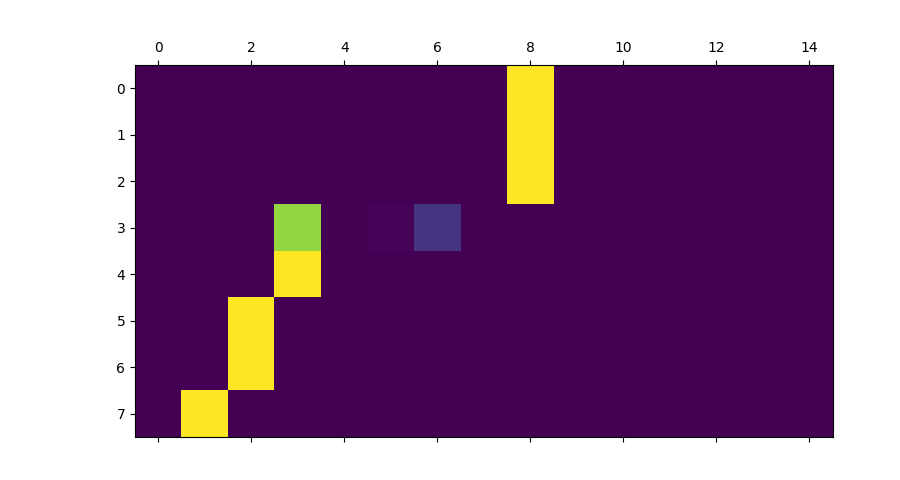

In [40]:
plt.matshow(attn_weight.numpy())

In [ ]:
attn_weight.numpy().sum(axis=1)

In [ ]:
n_iters = 10
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
training_pair = training_pairs[0]
input_tensor = training_pair[0]
target_tensor = training_pair[1]
print(input_tensor)
print(target_tensor)

In [ ]:
# list(map(lambda i: input_lang.index2word[i], input_tensor.cpu().numpy().flatten()))

In [ ]:
# list(map(lambda i: output_lang.index2word[i], target_tensor.cpu().numpy().flatten()))

In [ ]:
output_words, attentions = evaluate(
    encoder1, decoder1, ????)


In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

In [ ]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")
#evaluateAndShowAttention("elle est trop petit .")
#evaluateAndShowAttention("je ne crains pas de mourir .")
#evaluateAndShowAttention("c est un jeune directeur plein de talent .")

In [ ]:
gru = nn.GRU(3, 5)

In [ ]:
inp = torch.rand((1,1,3))
hid = torch.rand((1,1,5))
gru(inp, hid)

In [ ]:
inp.shape, hid.shape

In [ ]:
inp.dtype, hid.dtype

In [ ]:
inp = torch.rand((1,1,3))
#hid = torch.rand((1,1,5))
gru(inp, hid)

In [ ]:
import numpy as np
import random
import torch
from torch import nn

In [ ]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)
random.seed(12)
torch.backends.cudnn.deterministic=True

In [ ]:
rnn = nn.GRU(10, 20, 1)

### no iteration

In [ ]:
inp = torch.from_numpy(np.array(
    [
        [1,2,3,4,5,6,7,8,9,10],
        [11,12,13,14,15,16,17,18,19,20],
    ]
))

h = np.array(
    [
        [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        [21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],
    ]
)
h = h/100
h = torch.from_numpy(h)

In [ ]:
inp = inp.unsqueeze(0).float()
h = h.unsqueeze(0).float()
inp.sum(), h.sum()

In [ ]:
o, h = rnn(inp, h)
o.sum(), h.sum(), o.shape, h.shape

In [ ]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)
random.seed(12)
torch.backends.cudnn.deterministic=True

In [ ]:
rnn = nn.GRU(10, 20, 1)

### iteration

In [ ]:
inp_1 = torch.from_numpy(np.array(
    [
        [1,2,3,4,5,6,7,8,9,10],
        #[11,12,13,14,15,16,17,18,19,20],
    ]
))
inp_2 = torch.from_numpy(np.array(
    [
        #[1,2,3,4,5,6,7,8,9,10],
        [11,12,13,14,15,16,17,18,19,20],
    ]
))

In [ ]:
h_1 = np.array(
    [
        [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        #[21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],
    ]
)
h_2 = np.array(
    [
        #[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        [21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],
    ]
)
h_1 = h_1/100
h_2 = h_2/100
h_1 = torch.from_numpy(h_1)
h_2 = torch.from_numpy(h_2)

In [ ]:
# for i in [(inp_1, h_1), (inp_2, h_2)]:
#     ii, ih = i
#     ii = ii.unsqueeze(0).float()
#     ih = ih.unsqueeze(0).float()
#     o, h = rnn(ii, ih)
#     #break

In [ ]:
inp_1 = inp_1.unsqueeze(0).float()
inp_2 = inp_2.unsqueeze(0).float()
h_1 = h_1.unsqueeze(0).float()
o, h = rnn(inp_1, h_1)
o, h = rnn(inp_2, h)
o.sum(), h.sum(), o.shape, h.shape

In [ ]:
o.sum(), h.sum()